# Employee Attrition Analysis


## Data Understanding

### Preparing necessary libraries and data

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sqlalchemy import create_engine

In [34]:
employee_df = pd.read_csv(
    "https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv",
    encoding='windows-1252'
)
employee_df.tail(5)

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,1466,38,0.0,Travel_Rarely,168,Research & Development,1,3,Life Sciences,1,...,4,80,0,10,4,4,1,0,0,0
1466,1467,50,NaN,Travel_Rarely,813,Research & Development,17,5,Life Sciences,1,...,3,80,3,19,3,3,14,11,1,11
1467,1468,28,1.0,Travel_Rarely,1485,Research & Development,12,1,Life Sciences,1,...,4,80,0,1,4,2,1,1,0,0
1468,1469,40,0.0,Non-Travel,458,Research & Development,16,2,Life Sciences,1,...,2,80,1,6,0,3,4,2,0,0
1469,1470,19,1.0,Travel_Frequently,602,Sales,1,1,Technical Degree,1,...,1,80,0,1,5,4,0,0,0,0


In [35]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

In [36]:
employee_df.columns

Index(['EmployeeId', 'Age', 'Attrition', 'BusinessTravel', 'DailyRate',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'EmployeeCount', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### Combining related columns (aggregations)

In [37]:
# Experience Score

employee_df['ExperienceLevel'] = (
    employee_df['YearsAtCompany'] + employee_df['YearsInCurrentRole'] + employee_df['YearsWithCurrManager']
)

"""
0–5     → "Low Experience"
6–10    → "Moderate Experience"
11–15   → "High Experience"
16+     → "Very High Experience"
"""

'\n0–5     → "Low Experience"\n6–10    → "Moderate Experience"\n11–15   → "High Experience"\n16+     → "Very High Experience"\n'

In [38]:
# Job Stability

employee_df['JobStability'] = employee_df['TotalWorkingYears']/(employee_df['NumCompaniesWorked'] + 1)

"""
< 2      → "Low Stability"
2–4      → "Moderate Stability"
> 4      → "High Stability"
"""

'\n< 2      → "Low Stability"\n2–4      → "Moderate Stability"\n> 4      → "High Stability"\n'

In [39]:
# Work Pressure Index 

employee_df['WorkPressure'] = (
    employee_df['TrainingTimesLastYear'] * (employee_df['OverTime'] == 'Yes').astype(int)
) + employee_df['DistanceFromHome']


""""
0–10   → "Low Pressure"
11–20  → "Medium Pressure"
21+    → "High Pressure"
"""

'"\n0–10   → "Low Pressure"\n11–20  → "Medium Pressure"\n21+    → "High Pressure"\n'

In [40]:
# Engagement Score 

employee_df['Engagement'] = (
    employee_df['JobSatisfaction'] + employee_df['EnvironmentSatisfaction'] + 
    employee_df['JobInvolvement'] + employee_df['RelationshipSatisfaction']
)

""" 
4–7     → "Low Engagement"
8–11    → "Moderate Engagement"
12–13   → "High Engagement"
14–16   → "Very High Engagement"
"""

' \n4–7     → "Low Engagement"\n8–11    → "Moderate Engagement"\n12–13   → "High Engagement"\n14–16   → "Very High Engagement"\n'

In [41]:
# Drop some variables after combining them

vars_to_drop = [
    'JobSatisfaction', 
    'EnvironmentSatisfaction', 
    'JobInvolvement', 
    'RelationshipSatisfaction',  # used for EngagementScore

    'TrainingTimesLastYear', 
    'OverTime', 
    'DistanceFromHome',          # used for WorkPressureIndex

    'YearsAtCompany', 
    'YearsInCurrentRole', 
    'YearsWithCurrManager',      # used for ExperienceScore

    'NumCompaniesWorked',
    'TotalWorkingYears',        # used for JobStability
]

employee = employee_df.drop(columns=vars_to_drop)

### Converting several features to 'category' type

In [42]:
""" See the type of each variables with saving it to text file
because the vscode limit output display even if pandas itself is instructed to show more
"""

with open("coltypes.txt", "w") as f:
    for col in employee.columns:
        f.write(f"{col}: {employee[col].dtype}\n")

In [43]:
columns_to_categorize = ['Attrition', 'Education', 'JobLevel', 'WorkLifeBalance', 'ExperienceLevel', 'JobStability', 'WorkPressure', 'Engagement', 'StockOptionLevel']
for col in columns_to_categorize:
    if col in employee.columns:  #  Check if the column exists
        employee[col] = employee[col].astype('category')

print(employee.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   EmployeeId               1470 non-null   int64   
 1   Age                      1470 non-null   int64   
 2   Attrition                1058 non-null   category
 3   BusinessTravel           1470 non-null   object  
 4   DailyRate                1470 non-null   int64   
 5   Department               1470 non-null   object  
 6   Education                1470 non-null   category
 7   EducationField           1470 non-null   object  
 8   EmployeeCount            1470 non-null   int64   
 9   Gender                   1470 non-null   object  
 10  HourlyRate               1470 non-null   int64   
 11  JobLevel                 1470 non-null   category
 12  JobRole                  1470 non-null   object  
 13  MaritalStatus            1470 non-null   object  
 14  MonthlyI

### Drop unnecessary columns

In [44]:
# Drop the unnecessary column
columns_to_drop = ['EmployeeId', 'EmployeeCount']
employee = employee.drop(columns=columns_to_drop, axis=1, errors='ignore')
employee.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'Education', 'EducationField', 'Gender', 'HourlyRate', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'Over18',
       'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
       'StockOptionLevel', 'WorkLifeBalance', 'YearsSinceLastPromotion',
       'ExperienceLevel', 'JobStability', 'WorkPressure', 'Engagement'],
      dtype='object')

### Mapping for the categories' numbers to labels

In [45]:
# 1. Attrition
attrition_map = {
    1.0: 'Yes',
    0.0: 'No',
}
# Safe mapping with fallback for non-numeric values
def safe_map_attrition(x):
    try:
        return attrition_map[int(x)]
    except (ValueError, TypeError, KeyError):
        return x 
employee['Attrition'] = employee['Attrition'].map(attrition_map)

# 2. Education
edu_map = {
    1: 'Below College',
    2: 'College',
    3: 'Bachelor',
    4: 'Master',
    5: 'Doctor'
}
# Safe mapping with fallback for non-numeric values
def safe_map_edu(x):
    try:
        return edu_map[int(x)]
    except (ValueError, TypeError, KeyError):
        return x 
employee['Education'] = employee['Education'].map(edu_map)

# 3. Job Level
joblv_map = {
    1: 'Level 1',
    2: 'Level 2',
    3: 'Level 3',
    4: 'Level 4',
    5: 'Level 5'
}
# Safe mapping with fallback for non-numeric values
def safe_map_joblv(x):
    try:
        return joblv_map[int(x)]
    except (ValueError, TypeError, KeyError):
        return x 
employee['JobLevel'] = employee['JobLevel'].map(joblv_map)

# 4. Work Life Balance
wlb_map = {
    1: 'Low',
    2: 'Good',
    3: 'Excellent',
    4: 'Outstanding'
}
def safe_map_wlb(x):
    try:
        return wlb_map[int(x)]
    except (ValueError, TypeError, KeyError):
        return x 
employee['WorkLifeBalance'] = employee['WorkLifeBalance'].map(wlb_map)

# 5. ExperienceLevel (Bin into categories)
def map_experience(score):
    if score <= 5:
        return 'Low'
    elif score <= 10:
        return 'Moderate'
    elif score <= 15:
        return 'High'
    else:
        return 'Very High'

employee['ExperienceLevel'] = employee['ExperienceLevel'].apply(map_experience)

# 6. WorkPressure (Bin into categories)
def map_pressure(value):
    if value <= 10:
        return 'Low'
    elif value <= 20:
        return 'Medium'
    else:
        return 'High'

employee['WorkPressure'] = employee['WorkPressure'].apply(map_pressure)

# 7. Engagement (Bin into categories)
def map_engagement(score):
    if 4 <= score <= 7:
        return 'Low'
    elif 8 <= score <= 11:
        return 'Moderate'
    elif 12 <= score <= 13:
        return 'High'
    else:
        return 'Very High'

employee['Engagement'] = employee['Engagement'].apply(map_engagement)

# 8. JobStability
def map_job(score):
    if score < 2:
        return 'Low'
    elif 2 <= score <= 4:
        return 'Moderate'
    else:
        return 'High'
employee['JobStability'] = employee['JobStability'].apply(map_job)

# 9. Stock Option Level
stopt_map = {
    0: 'Level 0',
    1: 'Level 1',
    2: 'Level 2',
    3: 'Level 3'
}
# Safe mapping with fallback for non-numeric values
def safe_map_stopt(x):
    try:
        return stopt_map[int(x)]
    except (ValueError, TypeError, KeyError):
        return x 
employee['StockOptionLevel'] = employee['StockOptionLevel'].map(joblv_map)


### Visualization for numerical and categorical feature

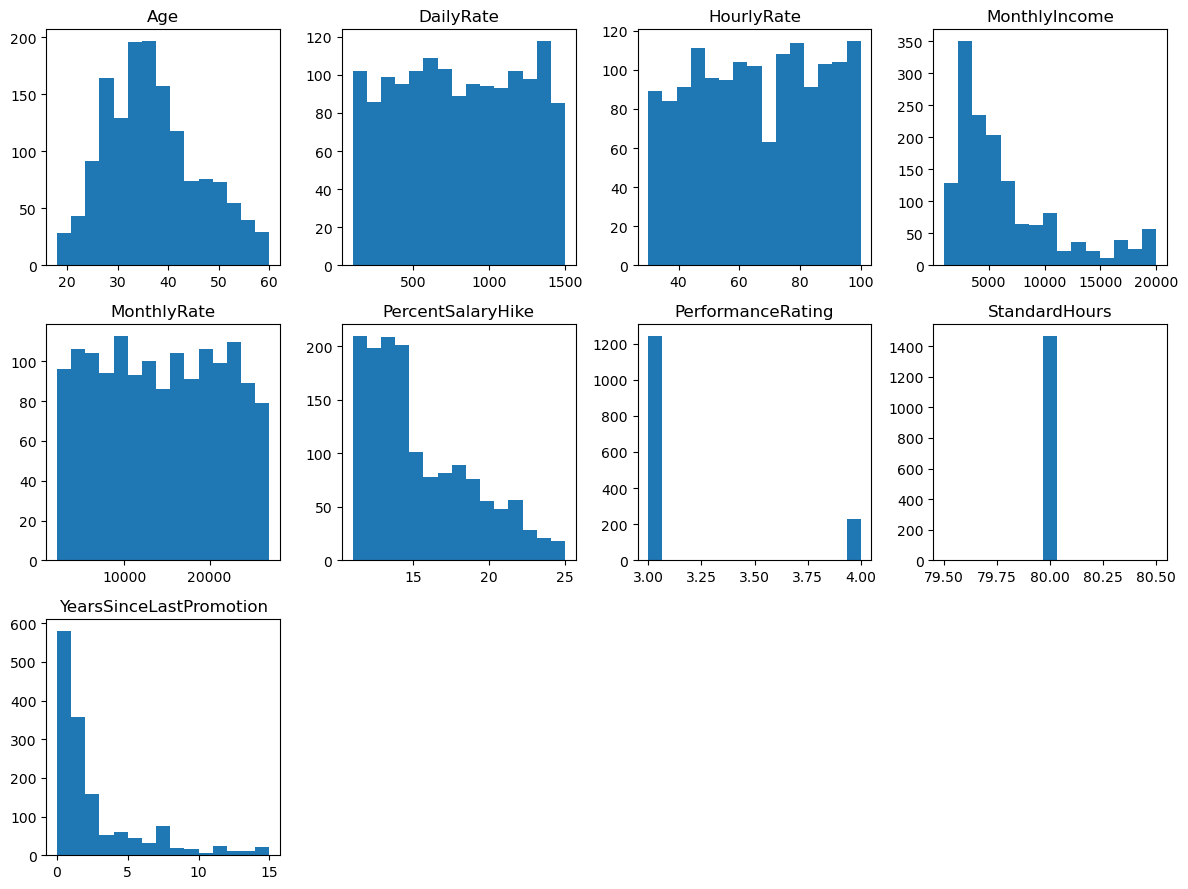

In [46]:
# Visualization for Numerical Features

numerical_cols = employee.select_dtypes(include=['number']).columns
num_cols = len(numerical_cols)
num_rows = (num_cols + 3) // 4 # Adjust rows based on the number of columns

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 3 * num_rows)) # Adjust figsize as needed
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_cols):
    axes[i].hist(employee[col], bins=15)
    axes[i].set_title(col)
    axes[i].grid(False) # Add titles to each subplot

# Remove any unused subplots if the number of numerical columns isn't a multiple of 4
if num_cols < len(axes):
    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\Dini\AppData\Local\Temp\ipykernel_12604\432094678.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right') # Align the rotated labels to the right
C:\Users\Dini\AppData\Local\Temp\ipykernel_12604\432094678.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right') # Align the rotated labels to the right
C:\Users\Dini\AppData\Local\Temp\ipykernel_12604\432094678.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right') # Align the rotated labels to the right
C:\Users\Dini\AppData\Local\Temp\ipykernel_12604\432094678.py:12: UserWarning: set_ticklabels() should 

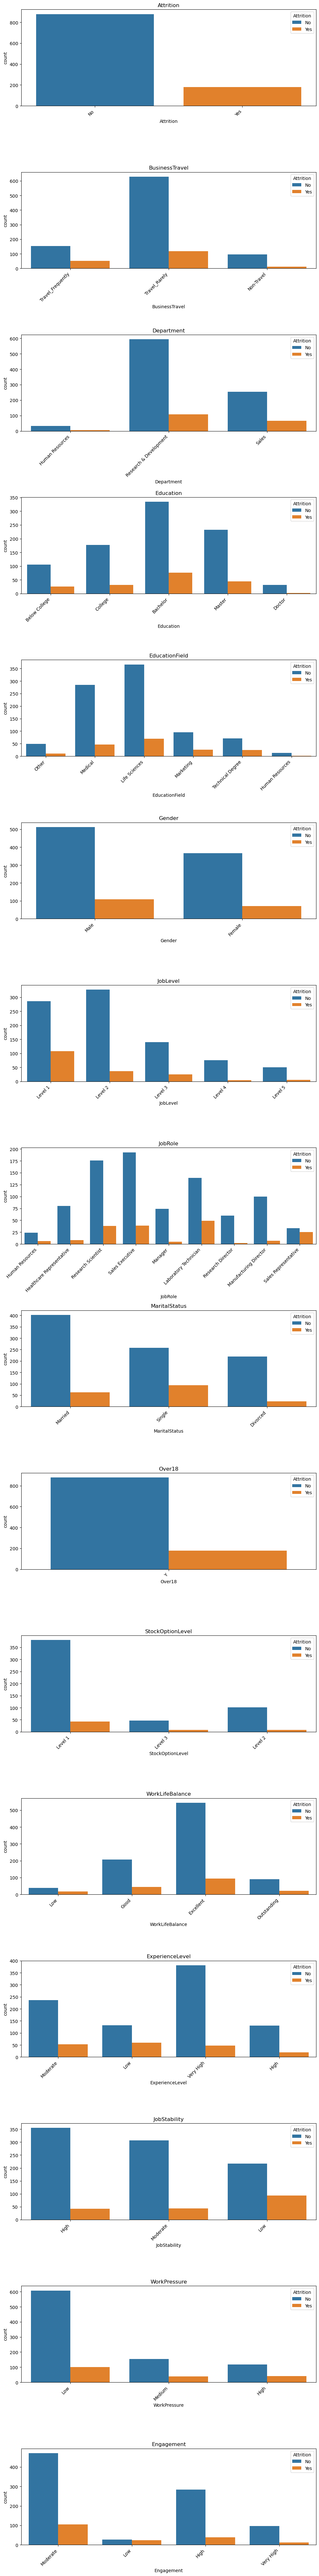

In [47]:
#Visualization for Categorical Features

categorical_cols = employee.select_dtypes(include=['object', 'category']).columns

num_categorical = len(categorical_cols)
fig, axes = plt.subplots(num_categorical, 1, figsize=(10, 5 * num_categorical))

for i, feature in enumerate(categorical_cols):
    sns.countplot(data=employee, x=feature, hue='Attrition', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=45) # Rotate the labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right') # Align the rotated labels to the right
    axes[i].legend(title='Attrition', loc='upper right')

plt.tight_layout()
plt.show()

## Data Preparation/Preprocessing

### Finding & Handling Missing Values

In [57]:
employee.isna().sum()

Age                        0
Attrition                  0
BusinessTravel             0
DailyRate                  0
Department                 0
Education                  0
EducationField             0
Gender                     0
HourlyRate                 0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
MonthlyRate                0
Over18                     0
PercentSalaryHike          0
PerformanceRating          0
StandardHours              0
StockOptionLevel           0
WorkLifeBalance            0
YearsSinceLastPromotion    0
ExperienceLevel            0
JobStability               0
WorkPressure               0
Engagement                 0
dtype: int64

In [58]:
# Handling Missing Value (fill with most frequent value)

categorical_cols = ['Attrition', 'StockOptionLevel']

for col in categorical_cols:
    employee[col].fillna(employee[col].mode()[0], inplace=True)

employee.isna().sum()

C:\Users\Dini\AppData\Local\Temp\ipykernel_12604\3295587171.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  employee[col].fillna(employee[col].mode()[0], inplace=True)


Age                        0
Attrition                  0
BusinessTravel             0
DailyRate                  0
Department                 0
Education                  0
EducationField             0
Gender                     0
HourlyRate                 0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
MonthlyRate                0
Over18                     0
PercentSalaryHike          0
PerformanceRating          0
StandardHours              0
StockOptionLevel           0
WorkLifeBalance            0
YearsSinceLastPromotion    0
ExperienceLevel            0
JobStability               0
WorkPressure               0
Engagement                 0
dtype: int64

### Finding & Handling Duplications

In [59]:
employee.duplicated().any()

np.False_

### Copying data for analysis in VSCode and for Metabase

In [60]:
# Data for Analysis
employee_ml = employee.copy()

# Data for dashboard
employee_dashboard = employee.copy()

### Preparing data for analysis (encoding, scaling, and splitting)

In [61]:
# Define features and target
X = employee_ml.drop('Attrition', axis=1)
y = employee_ml['Attrition']

In [62]:
# Encode categorical features in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X= pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

In [63]:
# Encode the target (y) separately
y = y.map({'No': 0, 'Yes': 1})

In [64]:
#  Scale numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [65]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling & Evaluation

### Random Forest

In [66]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

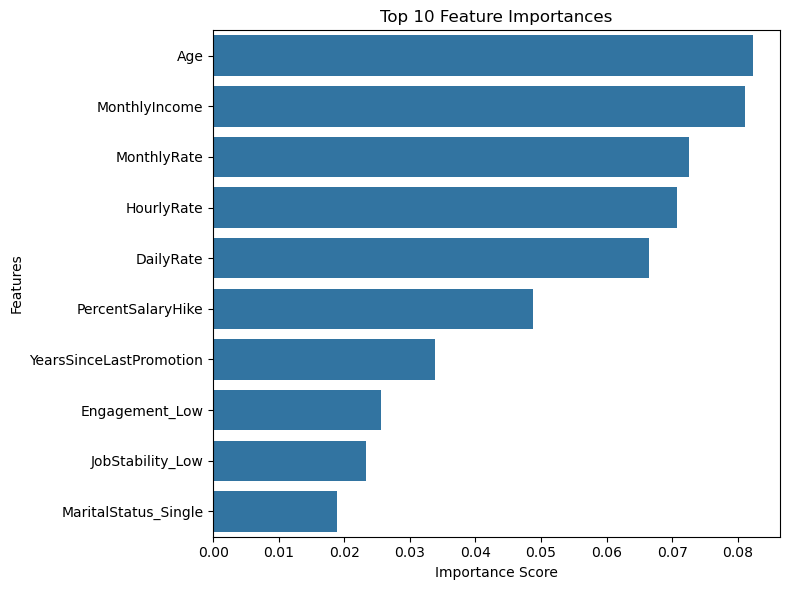

In [67]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

This plot shows the top 10 features ranked by how much they contribute to the model’s decisions.

In [68]:
rf_predictions = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       262
           1       0.00      0.00      0.00        32

    accuracy                           0.89       294
   macro avg       0.45      0.50      0.47       294
weighted avg       0.79      0.89      0.84       294



c:\Users\Dini\miniconda3\envs\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dini\miniconda3\envs\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dini\miniconda3\envs\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Logistic Regression

In [69]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

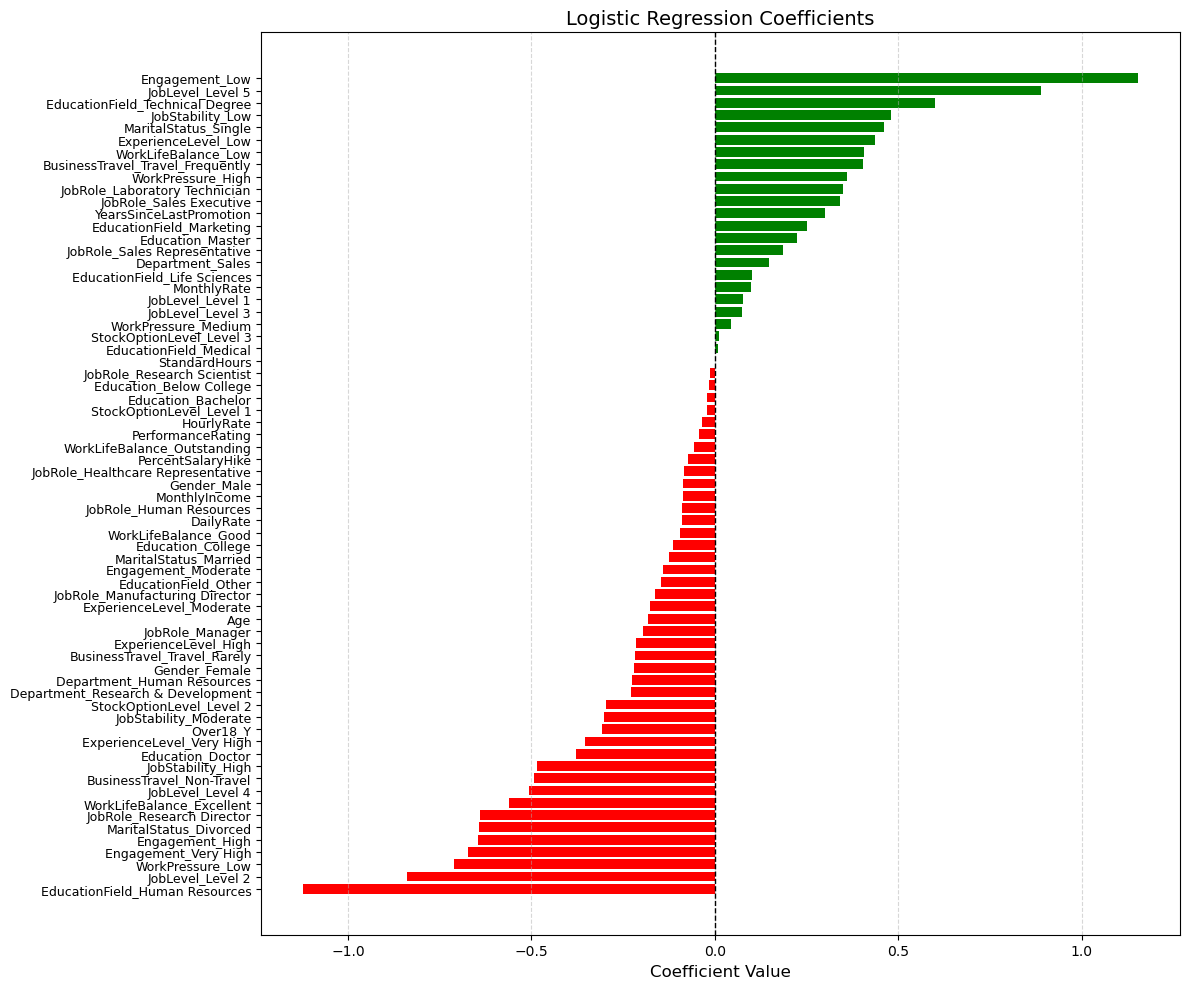

In [70]:
# Create a DataFrame of coefficients
coef = lr_model.coef_[0]
features = X_train.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})

# Sort by coefficient value
coef_df = coef_df.sort_values(by='Coefficient')

# Plot
plt.figure(figsize=(12, 10))
bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], 
                color=np.where(coef_df['Coefficient'] > 0, 'green', 'red'))

# Layout
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Logistic Regression Coefficients', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.show()

This bar chart displays the "Logistic Regression Coefficients" which indicate the direction and strength of the relationship between various features and the likelihood of employee attrition.

- **Positive Coefficients** (Green Bars to the Right):

These features *increase* the likelihood of attrition. The further a green bar is to the right, the stronger its positive association with attrition.

- **Negative Coefficients** (Red Bars to the Left):

These features *decrease* the likelihood of attrition. The further a red bar is to the left, the stronger its negative association with attrition.

In [71]:
lr_predictions = lr_model.predict(X_test)
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.93       262
           1       0.25      0.06      0.10        32

    accuracy                           0.88       294
   macro avg       0.57      0.52      0.52       294
weighted avg       0.82      0.88      0.84       294



## Save the Models

In [72]:
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

## Connect to MySQL

In [ ]:
# Database credentials and connection - MySQL
username = 'username' 
password = 'password'  
host = 'host'  
port = 'posrt'  
database = 'dashboard'  

# SQLAlchemy engine for MySQL
DATABASE_URL = f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}'

engine = create_engine(DATABASE_URL)

# Store DataFrame to MySQL
table_name = 'employees'  # Choose a table name
employee_dashboard.to_sql(table_name, engine, if_exists='replace', index=False)


1470